## Analysis of MonoBeams

New Boars of Jan are tested for monobeam recording

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from obspy.signal import PPSD

# from andbro__querrySeismoData import __querrySeismoData
from andbro__read_sds import __read_sds
from andbro__makeplot_trace_spectrogram import __makeplot_trace_spectrogram


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
def __get_inventory_from_client(config):

    from obspy.clients.fdsn import Client

    cli = Client(base_url=config['client'], timeout=100)

    try:
        inv = cli.get_stations(network=config['seed'].split(".")[0],
                               station=config['seed'].split(".")[1],
                               location=config['seed'].split(".")[2],
                               channel='*',
                               starttime=tbeg,
                               endtime=tend,
                               level="response")
    except:
        print(f"ERROR: failed to load inventory for {config['seed'].split('.')[1]}!")

    return inv

### Configurations

In [4]:
config = {}

config['ring'] = "U"

## define data seed
config['seeds'] = ["BW.DROMY..F1V",
                   "BW.DROMY..F2V",
                   "BW.DROMY..FJU",
                   "BW.ROMY..BJU"]

# config['seeds'] = ["BW.DROMY..FJV"]



# config['tbeg'] = UTCDateTime("2023-08-25 16:00")
# config['tend'] = UTCDateTime("2023-08-25 16:30")

## mit PMT in central shaft with gain 600 V
# config['tbeg'] = UTCDateTime("2023-08-31 15:15")
# config['tend'] = UTCDateTime("2023-08-31 15:20")

## mit PD in central shaft with postampdiff boxes
# config['tbeg'] = UTCDateTime("2023-09-01 14:15")
# config['tend'] = UTCDateTime("2023-09-01 14:30")

## should be good working according to signal plot
# config['tbeg'] = obs.UTCDateTime("2023-09-07 00:00")
# config['tend'] = obs.UTCDateTime("2023-09-07 00:15")

## new board installed for one monobeam (PD on high gain setting!)
# config['tbeg'] = obs.UTCDateTime("2023-11-17 16:30")
# config['tend'] = obs.UTCDateTime("2023-11-17 16:40")

## new boards installed for both monobeams at north ring
config['tbeg'] = obs.UTCDateTime("2023-11-23 15:10")
config['tend'] = obs.UTCDateTime("2023-11-23 15:12")

## checkup
config['tbeg'] = obs.UTCDateTime("2024-01-23 15:10")
config['tend'] = obs.UTCDateTime("2024-01-23 15:20")

## path to SDS data archive
config['path_to_sds'] = archive_path+"romy_archive/"

## path to signal data
config['path_to_data'] = archive_path+f"romy_autodata/{config['tbeg'].year}/R{config['ring']}/"

## path to store figures
config['path_to_figs'] = data_path+"mono_beams/figures/"

### Load Data

 -> loading BW.DROMY..F1V...
 -> loading BW.DROMY..F2V...
 -> loading BW.DROMY..FJU...
 -> loading BW.ROMY..BJU...


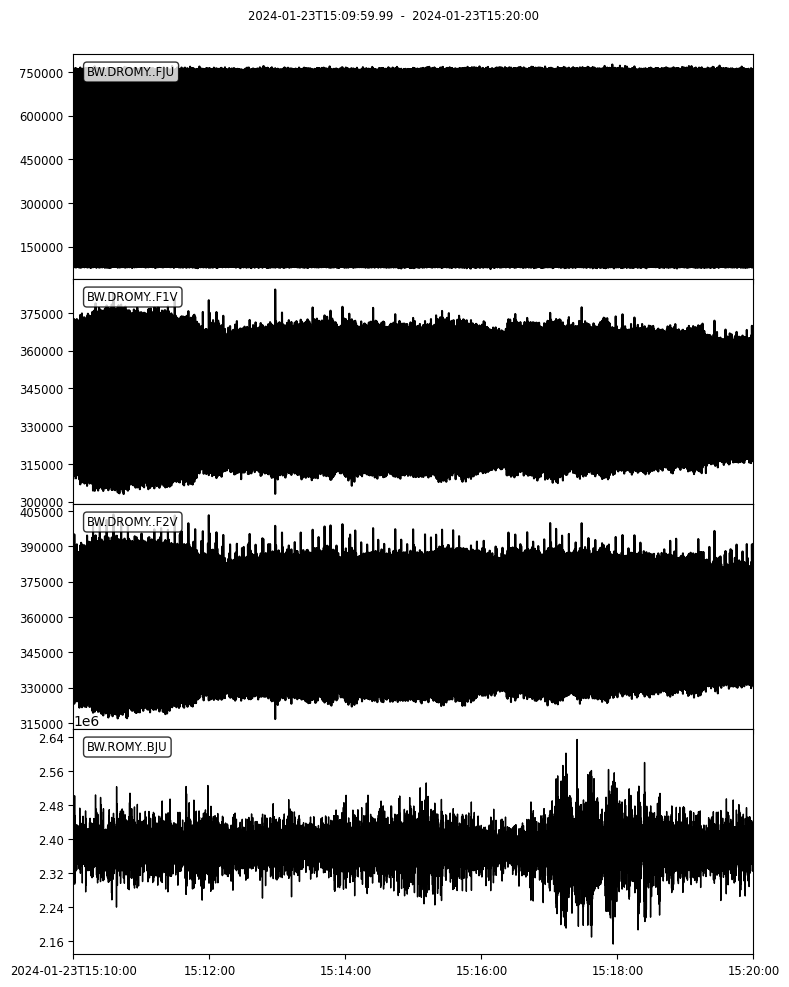

In [5]:
st0 = obs.Stream()

for seed in config['seeds']:

    print(f" -> loading {seed}...")

    try:
        st00 = __read_sds(config['path_to_sds'], seed, config['tbeg'], config['tend'], data_format='MSEED')
    except:
        print(f" -> failed for {seed}")

    st0 += st00

st0 = st0.sort()

st0.plot(equal_scale=False);

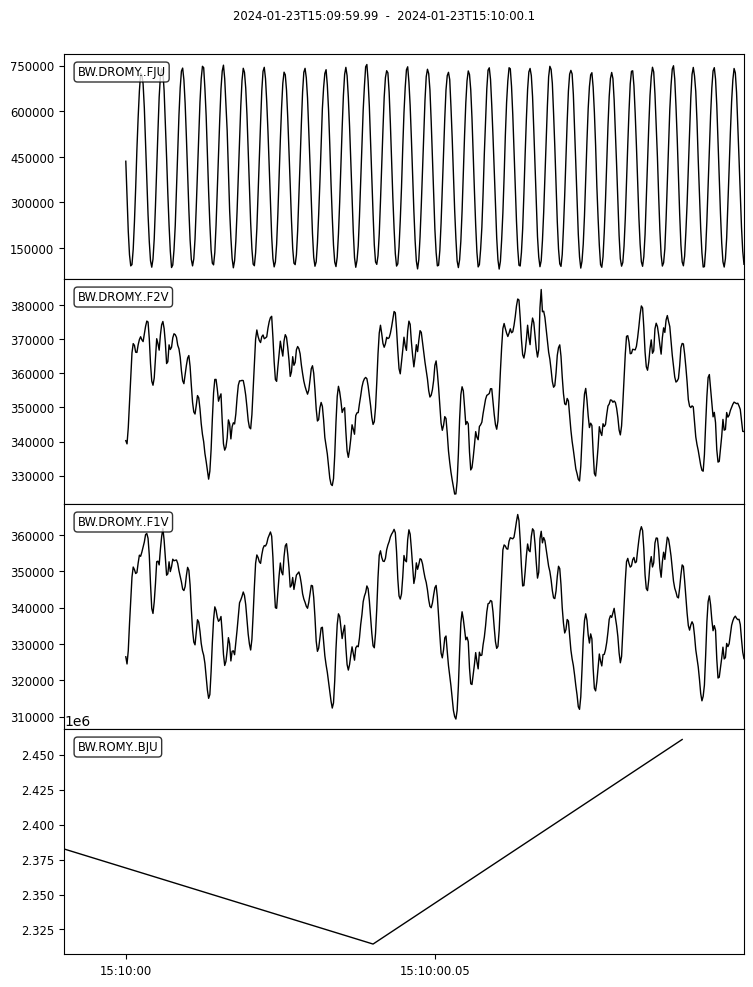

In [6]:
st0.copy().trim(config['tbeg'], config['tbeg']+0.1).plot(equal_scale=False);

## Modify Data

In [7]:
st = st0.copy()

st = st.split().merge(fill_value="interpolate")

st = st.sort(['channel'])

### convert from counts to volts: 0.59604645ug  from obsidian

In [8]:
for tr in st:
    if tr.stats.station == "DROMY":
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

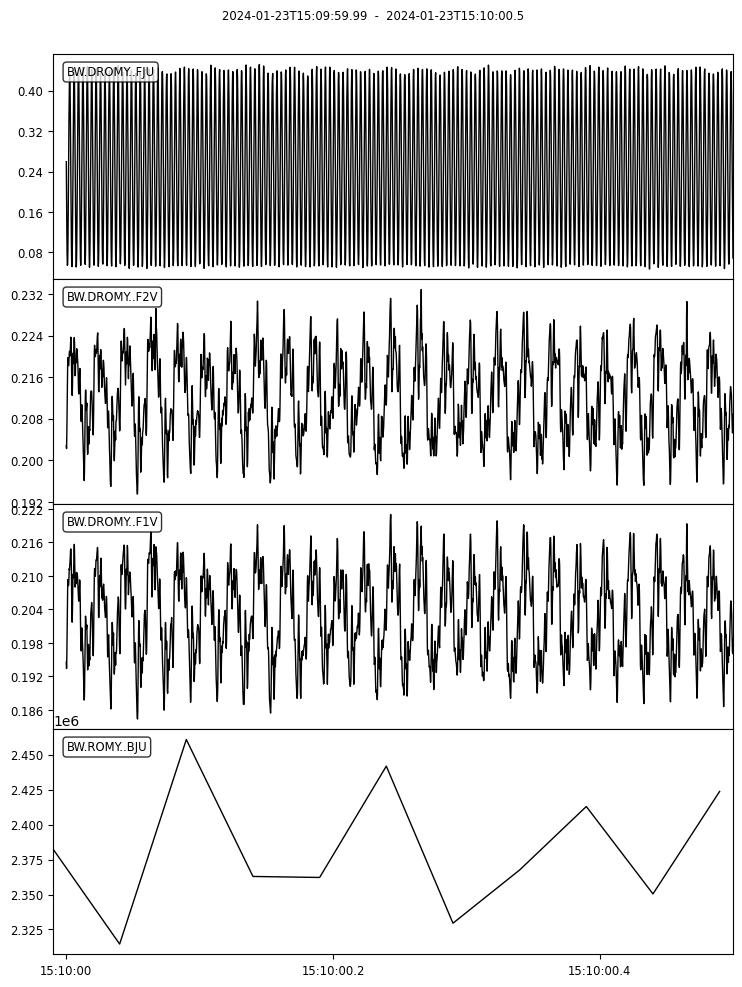

In [9]:
st.copy().sort().trim(config['tbeg'], config['tbeg']+0.5).plot(equal_scale=False);

### Plot PSD

In [10]:
def __makeplot_stream_PSD(st, twin_sec, f_lower_zoom=540, f_upper_zoom=560):

    from scipy import fftpack
    from numpy import abs
    from scipy import signal
    import matplotlib.pyplot as plt

    def __fft(signal_in, dt, window=None):

        from scipy.fft import fft, fftfreq, fftshift
        from scipy import signal
        from numpy import angle

        ## determine length of the input time series
        n = int(len(signal_in))


        ## calculate spectrum (with or without window function applied to time series)
        if window:
            win = signal.get_window(window, n);
            spectrum = fft(signal_in * win)

        else:
            spectrum = fft(signal_in)

        ## calculate frequency array 
        frequencies = fftfreq(n, d=dt)


        ## correct amplitudes of spectrum
        magnitude = 2.0 / n * abs(spectrum)


        phase = angle(spectrum, deg=False)
        # phase = imag(spectrum)

        ## return the positive frequencies
        return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]


    nblock = int(st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)

    print(f" -> nseg = {nblock} | overlap = {overlap}")

    win = signal.get_window("hann", nblock)


    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(st):

        ff, Pxx = signal.welch(tr.data, fs=tr.stats.sampling_rate,
                                window=win, noverlap=overlap, nfft=nblock,
                                scaling="density",
                                return_onesided=True,
                              )

        # ff, Pxx, ph = __fft(tr.data,
        #                     tr.stats.delta,
        #                     window="hann",
        #                    )


        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()[:400],
                    tr.data[:400],
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].semilogy(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )

        axes[i,1].set_ylim(min(Pxx[10:]), max(Pxx[10:]))

        axes[i,0].set_ylabel(r'U (volt)')

        axes[i,1].set_ylabel(r'PSD (volt$^2$/Hz)')

        axes[i,0].legend(loc='upper left', framealpha=.8)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(f_lower_zoom, f_upper_zoom)
        axes[i,1].set_ylim(1e-10, 1e0)


    plt.show();
    return fig, (Pxxs, ffs, chs)

 -> nseg = 300000 | overlap = 150000


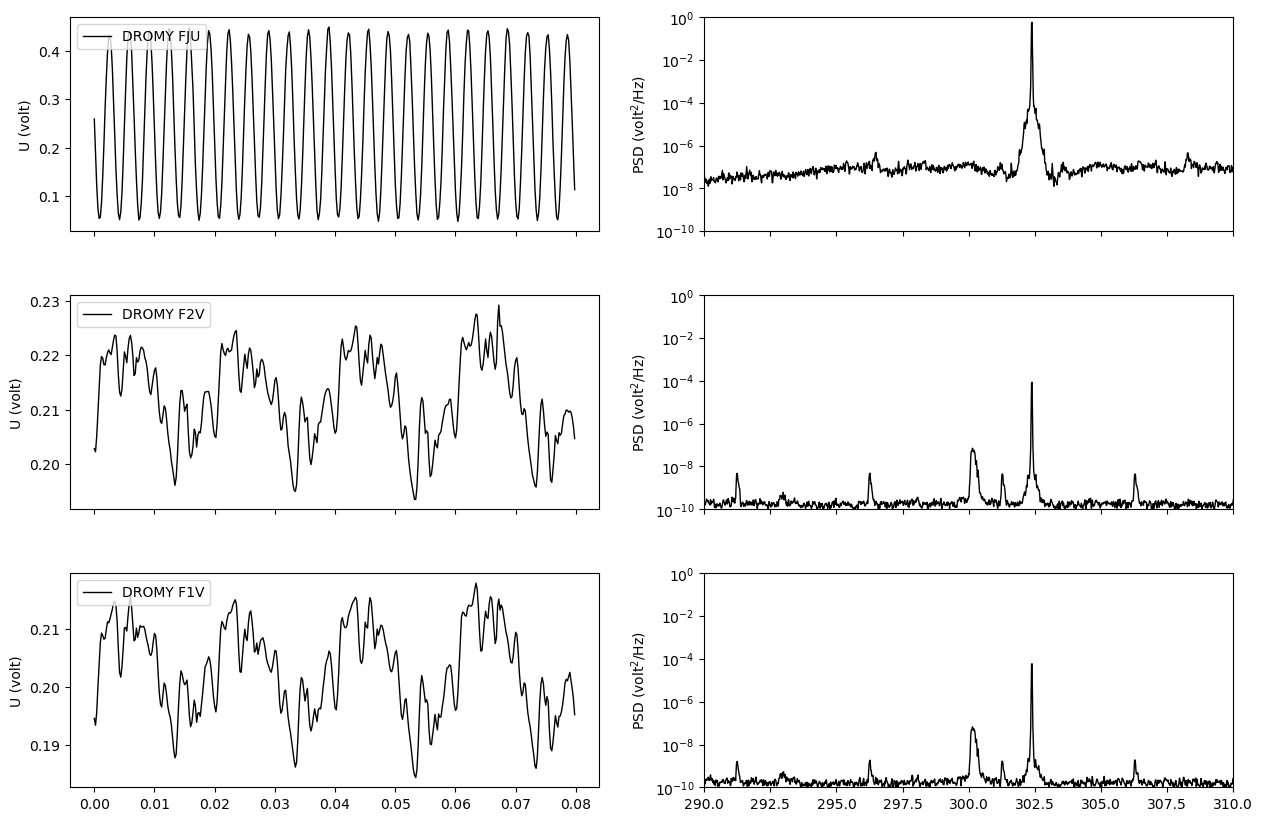

In [11]:
stx = st.select(station="DROMY")

fig, out = __makeplot_stream_PSD(stx, twin_sec=60, f_lower_zoom=290, f_upper_zoom=310);

fig.savefig(config['path_to_figs']+f"Monobeams_Nordring_{stx[0].stats.starttime.date}_trace&PSD.png", format="png", dpi=200, bbox_inches='tight')

## Spectrogram

In [12]:
# params = [1048, 128, 32]

# for tr in stx:
#     __makeplot_trace_spectrogram(tr, unit='hour', normalize=True, spec_param=params);

# plt.show();

## PSD Overview

In [13]:
def __makelot_psd():

    plt.figure(figsize=(15, 10))

    for f, pxx, cha in zip(ffs, Pxxs, chs):

        if cha == "FJZ":
            plt.plot(f, pxx, label=cha, zorder=1)
        else:
            plt.plot(f, pxx, label=cha, zorder=2)

        plt.xscale("log")
        plt.yscale("log")

    #     plt.xlim(500, 560)

        plt.ylim(1e-10, 1e-3)

        plt.legend(loc=1)

        plt.ylabel(r"PSD (V/$\sqrt{Hz}$)", fontsize=14)
        plt.xlabel("Frequency (Hz)", fontsize=14)

        plt.grid(which="both", ls=":", zorder=-1, alpha=0.7)

    plt.show();
    return fig

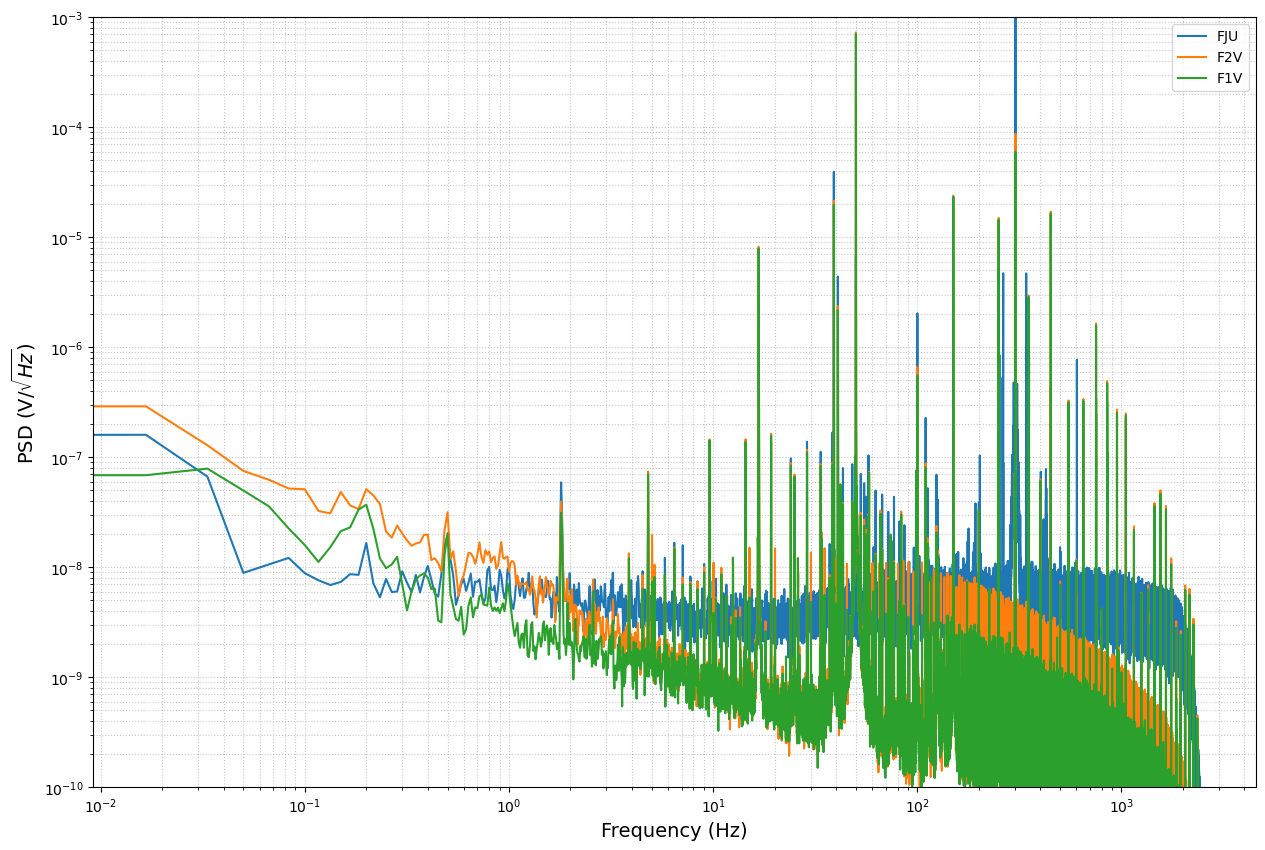

In [14]:
Pxxs, ffs, chs = out[0], out[1], out[2]

fig = __makelot_psd()

fig.savefig(config['path_to_figs']+f"Monobeams_Nordring_PSDoverview_{stx[0].stats.starttime.date}.png", format="png", dpi=200, bbox_inches='tight')

In [15]:
Pxxs, ffs, chs = out[0], out[1], out[2]

In [16]:
def __makeplot_psd_overview_with_zoomin(Pxxs, ffs, chs):

    from matplotlib.gridspec import GridSpec

    font = 14


    fig = plt.figure(figsize=(15,8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(1, 2, width_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0])
    ax1.semilogx(ffs[0], 20*np.log10(Pxxs[0]), alpha=0.5, color="tab:blue", label=chs[0])
    ax1.semilogx(ffs[1], 20*np.log10(Pxxs[1]), alpha=0.5, color="tab:orange", label=chs[1])
    ax1.semilogx(ffs[2], 20*np.log10(Pxxs[2]), alpha=0.5, color="tab:green", label=chs[2], zorder=2)

    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.set_ylabel(f"PSD (dB rel. to (1 $V^2$/Hz))", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)

    ax1.set_ylim(-300, 0)



    ax2 = fig.add_subplot(gs[1])
    ax2.plot(ffs[0], 20*np.log10(Pxxs[0]), alpha=0.5, color="tab:blue")
    ax2.plot(ffs[1], 20*np.log10(Pxxs[1]), alpha=0.5, color="tab:orange")
    ax2.plot(ffs[2], 20*np.log10(Pxxs[2]), alpha=0.5, color="tab:green", zorder=2)

    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)
    ax2.set_yticklabels([])

    ax2.set_ylim(-300, 0)
    ax2.set_xlim(302-10, 302+10)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    time_str = f"{str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    ax1.set_title(f"{stx[0].stats.starttime.date} {time_str}")

    plt.show();
    return fig

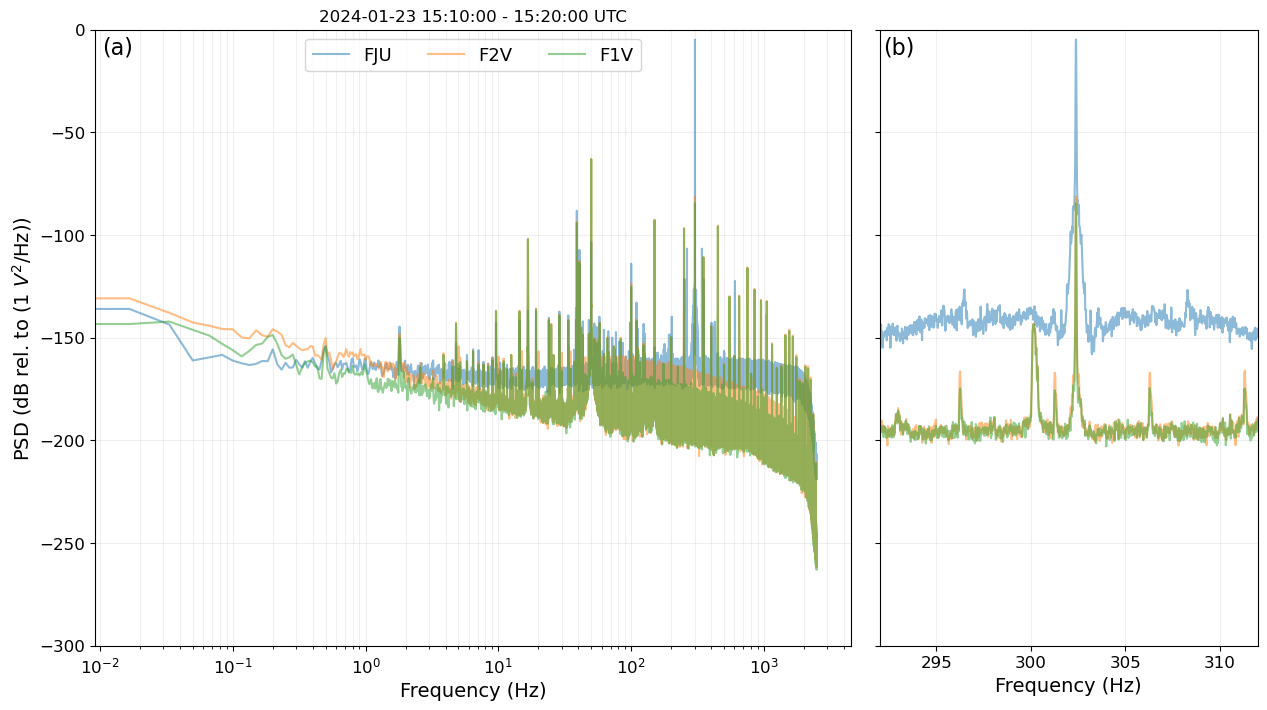

In [17]:
fig = __makeplot_psd_overview_with_zoomin(Pxxs, ffs, chs)

fig.savefig(config['path_to_figs']+f"Monobeams_Nordring_{stx[0].stats.starttime.date}.png", format="png", dpi=200, bbox_inches='tight')

### Plot Saganc Frequency

In [18]:
config['path_to_data']+f"{config['tbeg'].year}/R{config['ring']}/FJ{config['ring']}_{config['tbeg'].year}{config['tbeg'].month}{config['tbeg'].day}.pkl"

'/home/andbro/freenas/romy_autodata/2024/RU/2024/RU/FJU_2024123.pkl'

In [19]:
from pandas import read_pickle

date_str = f"{config['tbeg'].year}{str(config['tbeg'].month).rjust(2,'0')}{str(config['tbeg'].day).rjust(2,'0')}"

df = read_pickle(config['path_to_data']+f"/FJ{config['ring']}_{date_str}.pkl")

df.sort_values(by="times_mjd", inplace=True)

df.reset_index(drop=True, inplace=True)

df

FileNotFoundError: [Errno 2] No such file or directory: '/home/andbro/freenas/romy_autodata/2024/RU//FJU_20240123.pkl'

In [ ]:
def __makeplot_overview2(df):


    N = 5
    font = 12
    ms = 5

    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    # plt.subplots_adjust(wspace=0.2)


    ## ______________________________

    ax[0].scatter(df.times_mjd, df.fj, c="tab:blue", label="FJ", s=ms, alpha=0.4, zorder=2)
    ax[0].scatter(df.times_mjd, df.f1, c="tab:orange", label="CCW", s=ms, alpha=0.4, zorder=2)
    ax[0].scatter(df.times_mjd, df.f2, c="tab:red", label="CW", s=ms, alpha=0.4, zorder=2)

    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[0].set_ylabel("Freq. (Hz)", fontsize=font)
    ax[0].legend(loc=1, fontsize=font-2, ncol=3, bbox_to_anchor=(1, 1.3))


    ## ______________________________

    ax[1].scatter(df.times_mjd, df.fj, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[1].scatter(df.times_mjd, df.f1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[1].scatter(df.times_mjd, df.f2, c="tab:red", s=ms, alpha=0.4, zorder=2)

    ax[1].set_ylim(df.fj.mean()-2*df.fj.std(), df.fj.mean()+2*df.fj.std())
    ax[1].ticklabel_format(useOffset=False, style='plain')
    ax[1].set_ylabel("Freq. (Hz)", fontsize=font)

    ## ______________________________

    ax[2].scatter(df.times_mjd, df.ac_z, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[2].scatter(df.times_mjd, df.ac_1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[2].scatter(df.times_mjd, df.ac_2, c="tab:red", s=ms, alpha=0.4, zorder=2)


    ax[2].set_ylim(0, 0.5)
    ax[2].set_ylabel("AC (V)", fontsize=font)

    ## ______________________________

    ax[3].scatter(df.times_mjd, df.dc_z, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[3].scatter(df.times_mjd, df.dc_1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[3].scatter(df.times_mjd, df.dc_2, c="tab:red", s=ms, alpha=0.4, zorder=2)

    ax[3].set_ylabel("DC (V)", fontsize=font)

    ## ______________________________

    ax[4].scatter(df.times_mjd, df.contrast_z, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[4].scatter(df.times_mjd, df.contrast_1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[4].scatter(df.times_mjd, df.contrast_2, c="tab:red", s=ms, alpha=0.4, zorder=2)

    ax[4].set_ylim(0, 0.5)
    ax[4].set_ylabel("Contrast (V)", fontsize=font)



    for n in range(N):
        ax[n].grid(alpha=0.8, ls=":", zorder=0)


    ax[N-1].set_xlabel("Time (mjd)")
    ax[0].set_title("ROMY-Z Sagnac Signal ", fontsize=font+1, pad=10)


    return fig

In [ ]:
__makeplot_overview2(df);